In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
from datetime import date
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
# download 2 stocks
s1 = yf.download('jpm', date(2019, 6, 1), date(2022, 7, 1))
s2 = yf.download('ms', date(2019, 6, 1), date(2022, 7, 1))
ma = 63
data = pd.DataFrame({'s1':s1['Adj Close'], 's2':s2['Adj Close']}, index = s1.index)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,s1,s2
Date,,
2019-06-03,96.553253,37.097771
2019-06-04,99.528008,38.691700
2019-06-05,99.881714,38.646164
2019-06-06,100.099403,38.992283
2019-06-07,99.002007,38.892082


Text(0.5, 1.0, 'JPM & MS Prices')

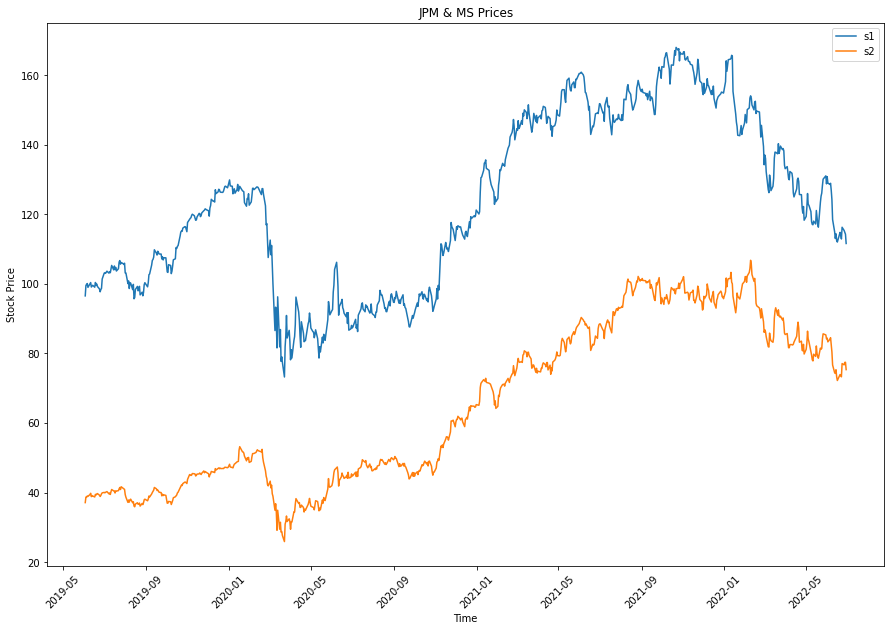

In [8]:
plt.plot(data['s1'])
plt.plot(data['s2'])
plt.xticks(rotation='45')
plt.legend(data.columns)
plt.rcParams["figure.figsize"] = (15,10)
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.title('JPM & MS Prices')

2019-06-03 00:00:00


Text(0.5, 1.0, 'Spread Z-Score')

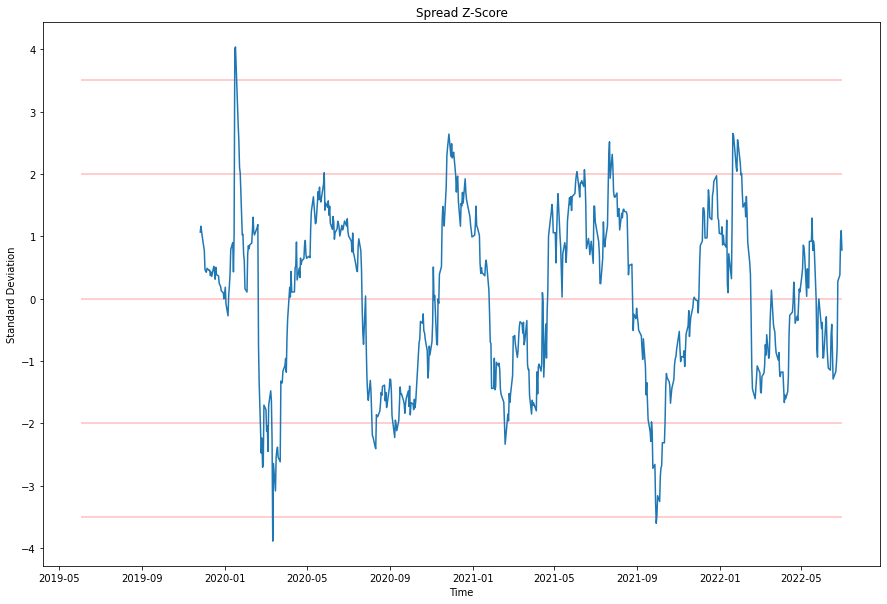

In [9]:
X1, X2 = np.log(data['s1']), np.log(data['s2'])
print(data.index[0])
# create hedge ratio using rolling regression with 63 day window
data['Hedge Ratio'] = RollingOLS(X2, X1, window=ma).fit().params
data['Spread_1'] = X2 - X1*data['Hedge Ratio']
# calculate z score
data['Z_Score'] = (data['Spread_1']-data['Spread_1'].rolling(window=ma).mean())/data['Spread_1'].rolling(window=ma).std()

# the red lines are:
# +/- 3.5 stop
# +/- 2 enter
# 0 exit

plt.plot(data['Z_Score'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score')

Text(0.5, 1.0, 'Spread Z-Score and Long-Trade Periods')

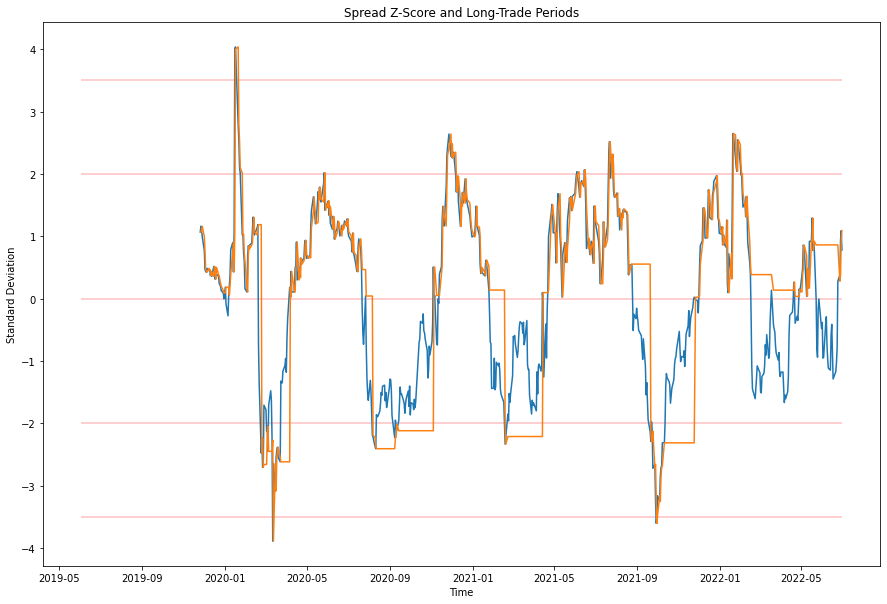

In [10]:
# given prices are daily close, we shift these periods by 1 day
# define regular long trade boundaries
data['Trade periods long'] = data['Z_Score'].where((data['Z_Score'] <= -2)|(data['Z_Score'] >= 0)).ffill().shift(1)

plt.plot(data['Z_Score'])
plt.plot(data['Trade periods long'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Long-Trade Periods')

Text(0.5, 1.0, 'Spread Z-Score and Short-Trade Periods')

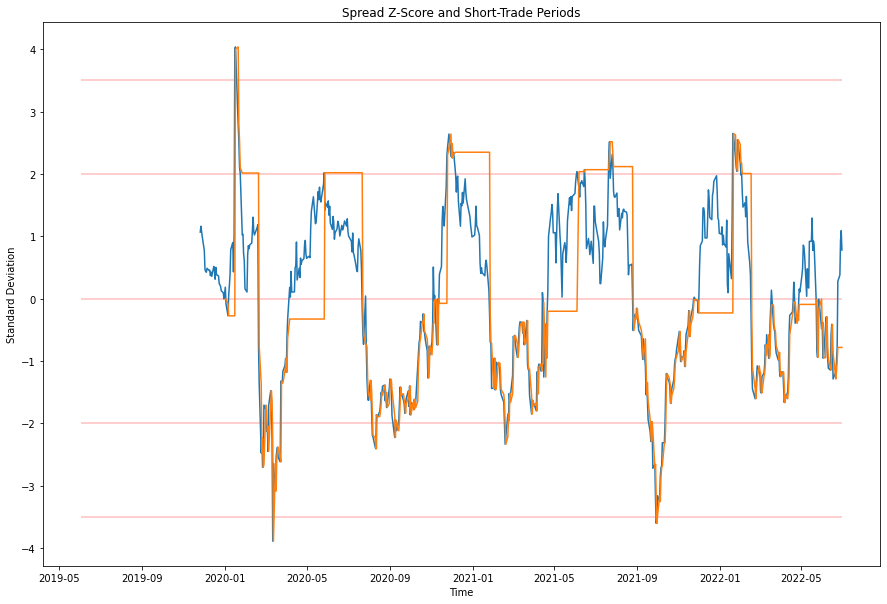

In [11]:
# define regular short trade boundaries
data['Trade periods short'] = data['Z_Score'].where((data['Z_Score'] >= 2)|(data['Z_Score'] <= 0)).ffill().shift(1)

plt.plot(data['Z_Score'])
plt.plot(data['Trade periods short'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Short-Trade Periods')

Text(0.5, 1.0, 'Spread Z-Score and Long-Stopped-Trade Periods')

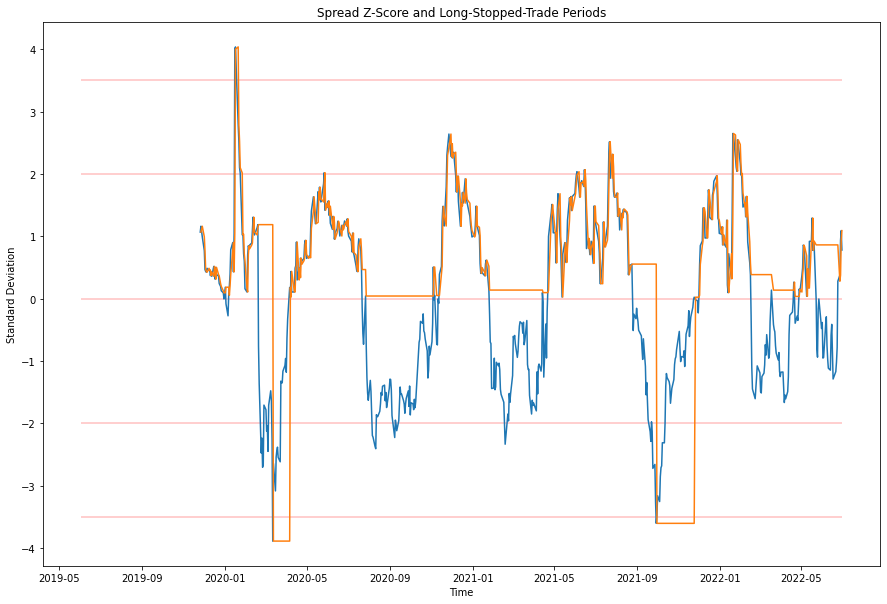

In [12]:
# define trade boundaries as if our stop threshold was our entry threshold
# we can then subtract these periods later from our regular entry trades to create a trade period as if it was stopped out
data['Trade periods stopped long'] = data['Z_Score'].where((data['Z_Score'] <= -3.5)|(data['Z_Score'] >= 0)).ffill().shift(1)

plt.plot(data['Z_Score'])
plt.plot(data['Trade periods stopped long'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Long-Stopped-Trade Periods')

Text(0.5, 1.0, 'Spread Z-Score and Short-Stopped-Trade Periods')

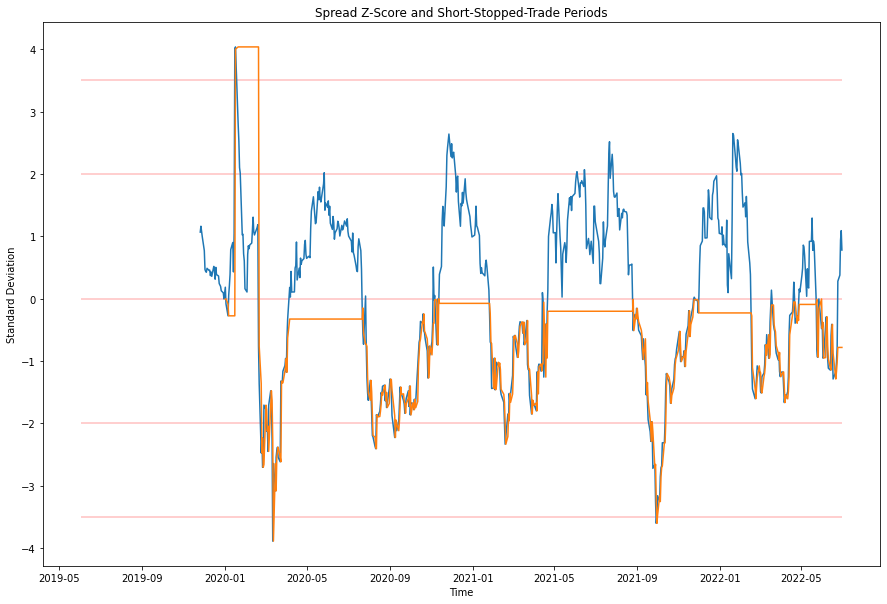

In [13]:
# define stopped short trade boundaries
data['Trade periods stopped short'] = data['Z_Score'].where((data['Z_Score'] >= 3.5)|(data['Z_Score'] <= 0)).ffill().shift(1)

plt.plot(data['Z_Score'])
plt.plot(data['Trade periods stopped short'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Short-Stopped-Trade Periods')

Text(0.5, 1.0, 'Spread Z-Score and Short Trades')

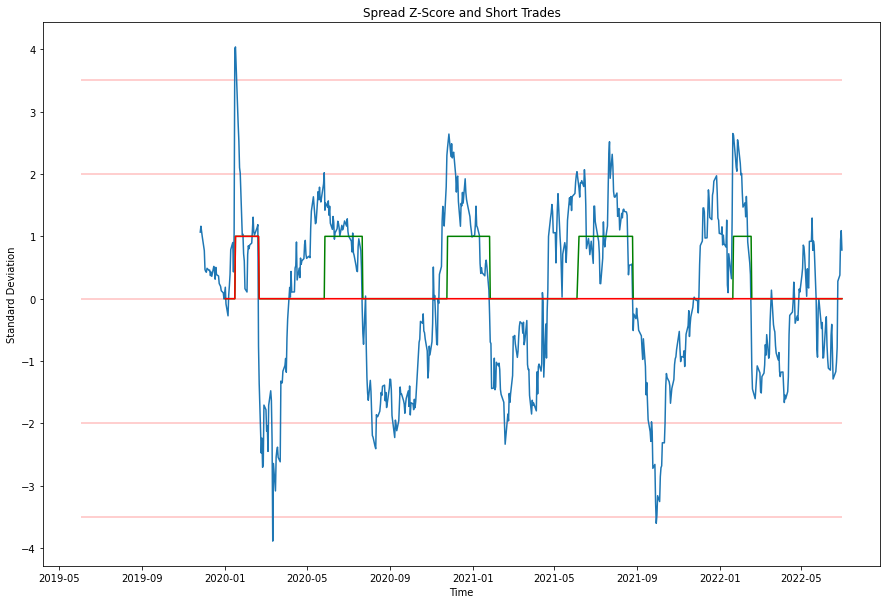

In [17]:
# create binary thresholds for short trades
data['Trades short'] = (np.sign(data['Trade periods short'])+1)/2
data['Trades stopped short'] = (np.sign(data['Trade periods stopped short'])+1)/2

plt.plot(data['Z_Score'])
plt.plot(data['Trades short'], color='g')
plt.plot(data['Trades stopped short'], color='r')
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Short Trades')

Text(0.5, 1.0, 'Spread Z-Score and Long Trades')

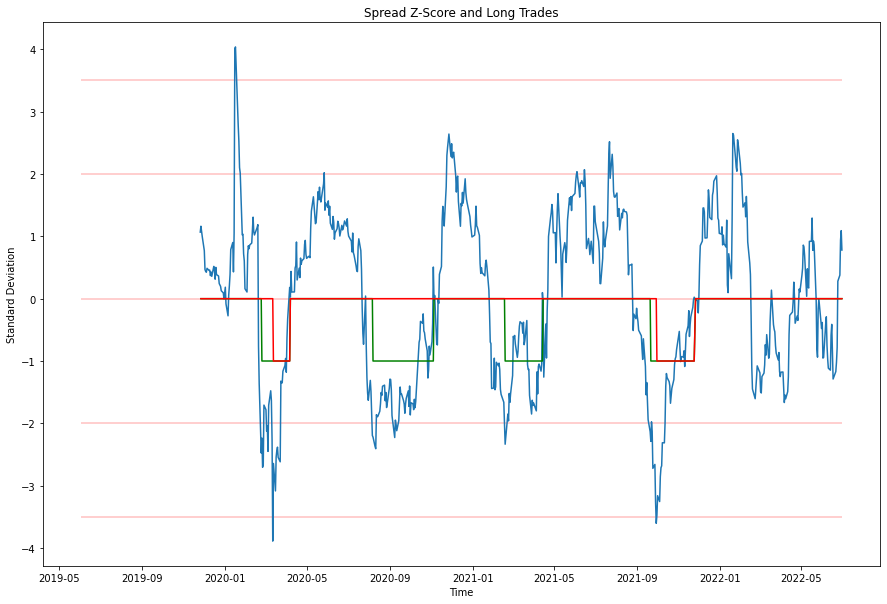

In [16]:
# create binary thresholds for long trades
data['Trades long'] = -(1-(np.sign(data['Trade periods long'])))/2
data['Trades stopped long'] = -(1-(np.sign(data['Trade periods stopped long'])))/2

plt.plot(data['Z_Score'])
plt.plot(data['Trades long'], color = 'g')
plt.plot(data['Trades stopped long'], color= 'r')
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and Long Trades')

Text(0.5, 1.0, 'Spread Z-Score and All Trade Periods')

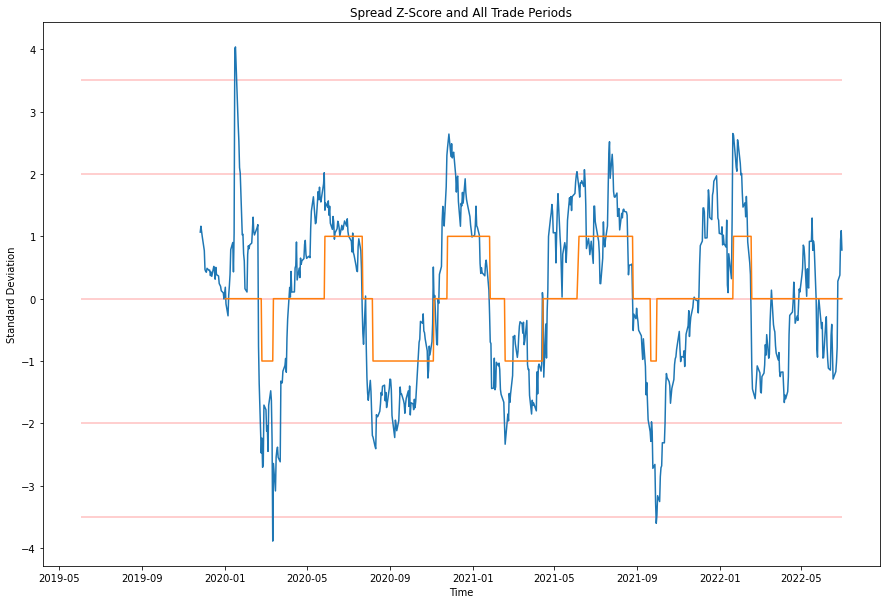

In [18]:
# sum trade thresholds 
data['all trades'] = data['Trades short'] + data['Trades long'] - data['Trades stopped short'] - data['Trades stopped long']

plt.plot(data['Z_Score'])
plt.plot(data['all trades'])
plt.hlines(y=[3.5, 2, 0, -2, -3.5], xmin=[data.index[0]], xmax=[data.index[-1]], color = 'r', alpha=0.25)
plt.ylabel('Standard Deviation')
plt.xlabel('Time')
plt.title('Spread Z-Score and All Trade Periods')

Text(0.5, 1.0, 'JPM/MS Pair Returns')

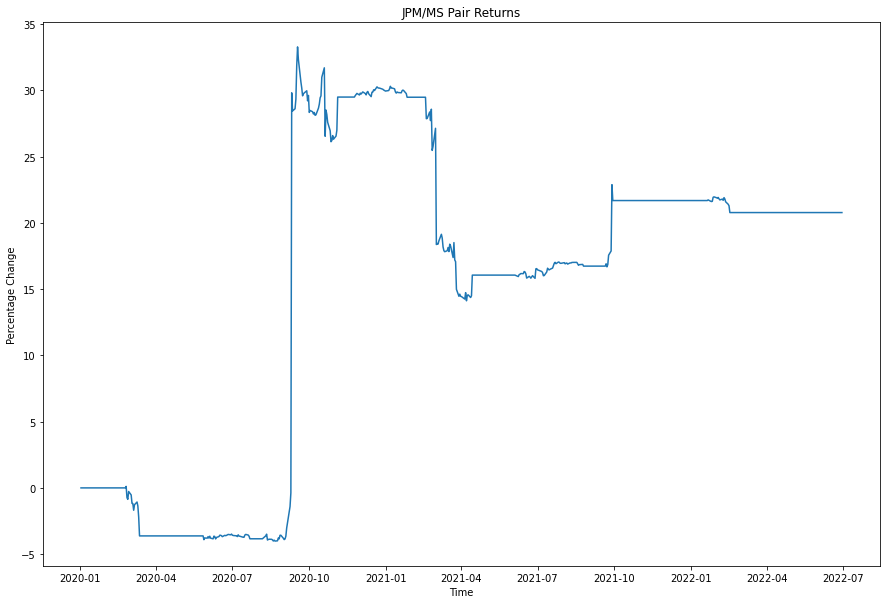

In [19]:
data['pair returns'] = ((((X2-data["Hedge Ratio"]*X1).pct_change()))*data['all trades']).cumsum()

plt.plot(data['pair returns'])
plt.ylabel('Percentage Change')
plt.xlabel('Time')
plt.title('JPM/MS Pair Returns')